# Проект - Интернет-магазин

## Описание проекта

В настоящем проекте нам предстоит провести анализ данных о потребительском поведении и финансовых результатах работы интернет-магазина «В один клик».

Согласно отчёту магазина за прошлый период, активность покупателей начала снижаться и следует выработать мероприятия для удержания постоянных клиентов с помощью персонализированных предложений.

**Задача проекта** - разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Импорт библиотек и функций

In [1]:
#базовые
import pandas as pd
import numpy as np
# отключение ошибок
import warnings
# графики
import seaborn as sns
import matplotlib.pyplot as plt
#анализ корреляции Phi_K 
!pip install phik -q
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
# преобразование данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# Модели
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# Метрики
#from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import make_scorer, confusion_matrix
# Инструменты подбора гиперпараметров
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
# пайплайны
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# анализ важности признаков
!pip install shap -q
import shap

RANDOM_STATE = 88

In [2]:
#функция первичного анализа данных
def data_report(df, show_info=True):
    temp = df.copy() 
    col_list = temp.columns
    print('='* 90)
    if show_info == True:
        print(temp.info())
#Поиск нулевых значений
    counter = 0
    for column in col_list:
        if temp[temp[column] == 0][column].count() > 0:
            counter += 1
    print('-'* 90)    
    print(f'Столбцов с нулевыми значениями: {counter}')
    print('-'* 90)    
    if counter > 0:
        print(f'Перечень столбцов с нулевыми значениями:')
        print('-'* 45)
        print(f'{"Имя поля":<40}{"Кол-во нулевых значений":<25}{"Процент к общему":<25}')
        print('-'* 90)
        for column in col_list:
            if temp[temp[column] == 0][column].count() > 0:
                print(f'{column :<40}'
                      f'{temp[temp[column] == 0][column].count():<25}'
                      f'{temp[temp[column] == 0][column].count()/len(temp):.2%}')                
#Поиск пропусков
    counter = 0
    for column in col_list:
        if temp[column].isna().sum() > 0:
            counter += 1
    print('-'* 90)    
    print(f'Столбцов с пропусками: {counter}')
    print('-'* 90)    
    if counter > 0:
        print(f'Перечень столбцов с пропусками:')
        print('-'* 45)
        print(f'{"Имя поля":<40}{"Кол-во пропусков":<25}{"Процент к общему":<25}')
        print('-'* 90)
        for column in col_list:
            if temp[temp[column] == 0][column].count() > 0:
                print(f'{column :<40}'
                      f'{temp[column].isna().sum():<25}'
                      f'{temp[column].isna().mean():.2%}')                
#Поиск явных дубликатов
    duplicates = temp.duplicated().sum()
    print('='* 90)
    print(f'Количество дубликатов по строкам: {duplicates}')
    print('='* 90)
    if duplicates > 0:
        print('Дублированные строки:')
        print('-'* 90)
        print(temp[temp.duplicated()==True][col_list[:3]])
        print('='* 90)
#Поиск неявных дубликатов
    string_columns = temp.select_dtypes(include='object').columns.tolist()
    print('Уникальные значения в тестовых полях')
    print('='* 90)
    for column in string_columns:
        values = temp[column].unique()
        if len(values) <= 25:
            print(f'{column}: {values}')
            print('-'* 90)
        else:
            print(f'В поле {column} слишком много значений')
            print('-'* 90)

In [3]:
#функция печати графиков для исследовательского анализа данных
def stat_plots(indicator, skip=[], nbins=10):
    if indicator.name not in skip:
        if indicator.dtype in ['int32', 'int64', 'float32', 'float64']:
            title1 = 'Гистограмма распределения'
            title2 = 'Диаграмма размаха'
            ind_label = indicator.name
            print('=' * 110)
            print(f'Статистический анализ показателя \033[1m {ind_label}')
            print('-' * 110)
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
            bins = axes[0].hist(indicator, bins=nbins)
            axes[0].vlines(x=indicator.mean(), colors='red', ymin=0, ymax=bins[0].max(), label='Среднее')
            axes[0].vlines(x=indicator.median(), colors='red', ymin=0, ymax=bins[0].max(), linestyles='--', label='Медиана')
            axes[0].set_title(title1)
            axes[0].set_xlabel(ind_label)
            axes[0].legend()
            axes[1].boxplot(indicator, vert=False)
            axes[1].set_title(title2)
            axes[1].set_xlabel(ind_label)
            plt.show()
        else:
            ind_label = indicator.name
            print('=' * 110)
            print(f'Распределение долей по показателю \033[1m {ind_label}')
            print('-' * 110)
            indicator.value_counts().plot(kind='pie', autopct='%.0f', subplots=True, legend=False, label=ind_label)
            plt.show()

In [4]:
#функция для расчета и вывода базовых метрик
def metrics_grid(y_true, y_pred):
    accuracy = round(accuracy_score(y_true, y_pred), 2)
    precision = round(precision_score(y_true, y_pred), 2)
    recall = round(recall_score(y_true, y_pred), 2)
    report = pd.DataFrame({'Метрика': ['Accuracy', 'Precision', 'Recall'], 'Значение': [accuracy, precision, recall]})
    return report

In [5]:
#функция рассчета метрики FNR
def get_false_negative_rate(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    return conf_matrix[1][0] / (conf_matrix[1][0] + conf_matrix[1][1])

## Загрузка и предобработка данных

### Загрузка данных

In [6]:
marketing = pd.read_csv('/datasets/market_file.csv')
revenue = pd.read_csv('/datasets/market_money.csv')
visits = pd.read_csv('/datasets/market_time.csv')
profit = pd.read_csv('/datasets/money.csv', sep=';', decimal = ',')

### Предобработка данных

In [7]:
data_report(revenue)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None
------------------------------------------------------------------------------------------
Столбцов с нулевыми значениями: 1
------------------------------------------------------------------------------------------
Перечень столбцов с нулевыми значениями:
---------------------------------------------
Имя поля                                Кол-во нулевых значений  Процент к общему         
------------------------------------------------------------------------------------------
Выручка                                 6                        0.15%
--------------------------------------------------------------------------------

In [8]:
revenue.head(3)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0


Данные в таблице с информацией о выручке в порядке, нулевые значения являются нормой.\
Есть смысл привести значения выручки к целым числам, поскольку для целей нашего анализа точность до копеек не имеет значения.

In [9]:
revenue['Выручка'] = revenue['Выручка'].astype('int32')

In [10]:
data_report(profit)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None
------------------------------------------------------------------------------------------
Столбцов с нулевыми значениями: 0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Столбцов с пропусками: 0
------------------------------------------------------------------------------------------
Количество дубликатов по строкам: 0
Уникальные значения в тестовых полях


In [11]:
profit.head(3)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13


Данные о прибыли, очевидно, исчисляются тысячами рублей - приведем эти данные к рублям для соответствия таблице выручки.

In [12]:
profit['Прибыль'] = (pd.to_numeric(profit['Прибыль'], errors='coerce') * 1000).astype('int32')

In [13]:
data_report(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None
------------------------------------------------------------------------------------------
Столбцов с нулевыми значениями: 0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Столбцов с пропусками: 0
------------------------------------------------------------------------------------------
Количество дубликатов по строкам: 0
Уникальные значения в тестовых полях
Период: ['текущий_месяц' 'предыдцщий_месяц']
------------------------------------------------------------------------------------------


In [14]:
visits.head(3)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10


Данные о посещениях сайта в порядке, за исключением опечатки в значениях - устраним ее:

In [15]:
visits['Период'] = visits['Период'].replace({'предыдцщий_месяц': 'предыдущий_месяц'})
visits['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> 👍</font>

In [16]:
data_report(marketing)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Заменим пробелы в названиях колонок на знаки подчеркивания:

In [17]:
marketing.columns = marketing.columns.str.replace(' ', '_')

Устраним неявные дубликаты в колонке Тип сервиса, вызванные опечаткой:

In [18]:
marketing['Тип_сервиса'] = marketing['Тип_сервиса'].replace({'стандартт': 'стандарт'})
marketing['Тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

### Промежуточный вывод

Данные в хорошем состоянии, правильных форматов, без пропусков и явных дубликатов.\
Устранено несколько опечаток, некоторые из которых приводили к дублированию данных.\
Заменены пробелы в названиях столбцов.\
Приведены к одной единице измерения и размерности данные о выручке и прибыли.

## Исследовательский анализ данных

### Анализ выручки и прибыли по клиентам

Определим функцию для вычисления совокупной выручки и нормы прибыли по клиентам:

In [19]:
def money_totals():
    total_revenue = revenue.pivot_table(index='id', values='Выручка', aggfunc='sum')
    money = total_revenue.merge(profit, on='id')
    money['Норма_прибыли'] = money['Прибыль'] / money['Выручка']
    return money

Изучим наличие аномалий в данных о выручке и прибыли:

In [20]:
money_totals().query('Норма_прибыли > 1')

,id,Выручка,Прибыль,Норма_прибыли
11,215359,4735,5080,1.072862


Аномалия обнаружена в единственном числе, поэтому можем удалить запись об этом клиенте без вреда для общего анализа.

In [21]:
revenue = revenue.drop(revenue[revenue['id'] == 215359].index)
profit = profit.drop(profit[profit['id'] == 215359].index)
visits = visits.drop(visits[visits['id'] == 215359].index)
marketing = marketing.drop(marketing[marketing['id'] == 215359].index)

Построим диаграмму размаха и числовое описание данных о выручке:

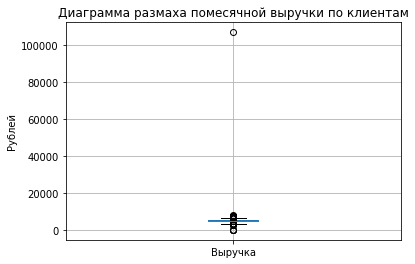

In [22]:
revenue.boxplot('Выручка')
plt.title('Диаграмма размаха помесячной выручки по клиентам')
plt.ylabel('Рублей')
plt.show()

In [23]:
revenue['Выручка'].describe()

count      3897.000000
mean       5028.157044
std        1774.707497
min           0.000000
25%        4591.000000
50%        4959.000000
75%        5363.000000
max      106862.000000
Name: Выручка, dtype: float64

In [24]:
revenue.query('Выручка == 106862')

,id,Период,Выручка
98,215380,текущий_месяц,106862


In [25]:
revenue.query('id == 215380')

,id,Период,Выручка
96,215380,препредыдущий_месяц,5051
97,215380,предыдущий_месяц,6077
98,215380,текущий_месяц,106862


Мы можем наблюдать единичный выброс в данных, который с большой вероятностью вызван опечаткой.\
Заменим величину этих данных на разумную для данного клиента:

In [26]:
revenue.at[98, 'Выручка'] = 6862

Нулевые данные о выручке также являются единичными выбросами, которые будут портить картину распределения - устраним их: 

In [27]:
zero_sales = revenue[revenue['Выручка'] == 0]['id'].unique().tolist()
zero_sales

[215348, 215357]

In [28]:
revenue = revenue.drop(revenue[revenue['id'].isin(zero_sales)].index)
profit = profit.drop(profit[profit['id'].isin(zero_sales)].index)
visits = visits.drop(visits[visits['id'].isin(zero_sales)].index)
marketing = marketing.drop(marketing[marketing['id'].isin(zero_sales)].index)

### Анализ распределения ежемесячной выручки

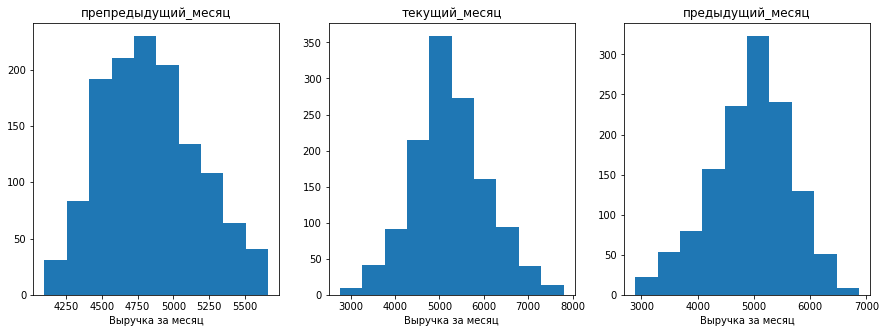

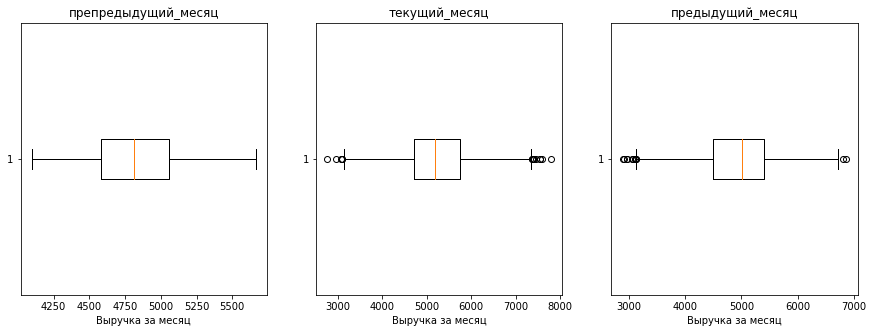

In [29]:
periods = revenue['Период'].unique()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for i in range(0, len(periods)):
    axes[i].hist(revenue[revenue['Период'] == periods[i]]['Выручка'], bins=10)
    axes[i].set_xlabel('Выручка за месяц')
    axes[i].set_title(periods[i])
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for i in range(0, len(periods)):    
    axes[i].boxplot(revenue[revenue['Период'] == periods[i]]['Выручка'], vert=False)
    axes[i].set_xlabel('Выручка за месяц')
    axes[i].set_title(periods[i])
plt.show()

In [30]:
periods = revenue['Период'].unique()
for i in range(0, len(periods)):
    print(f'{periods[i]:<40}{revenue[revenue["Период"] == periods[i]]["Выручка"].median()}')

препредыдущий_месяц                     4812.0
текущий_месяц                           5180.0
предыдущий_месяц                        5005.0


### Анализ прибыльности клиентов

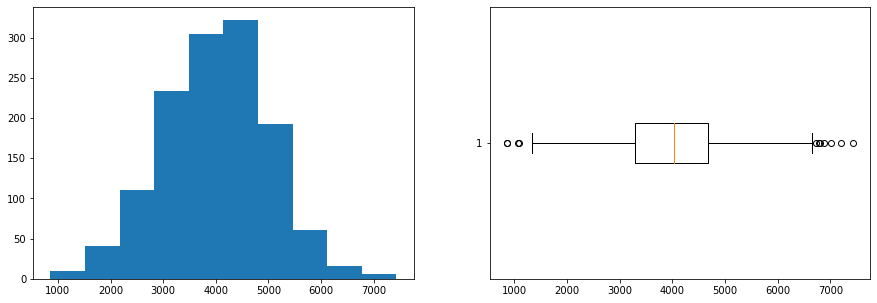

In [31]:
profit_ = profit.set_index('id')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axes[0].hist(profit_, bins=10)
axes[1].boxplot(profit_, vert=False)
plt.show()

### Продолжительность сессий на сайте

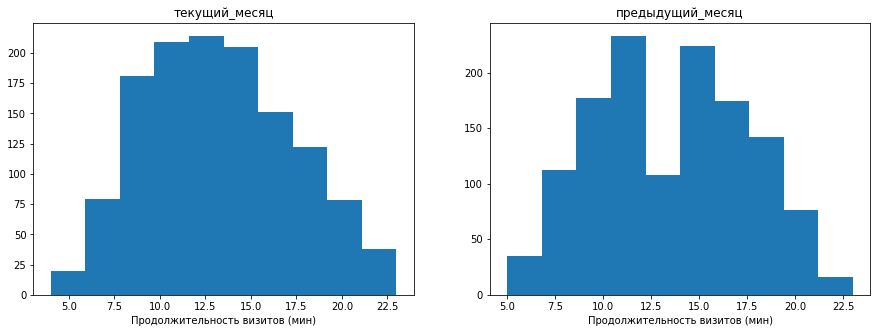

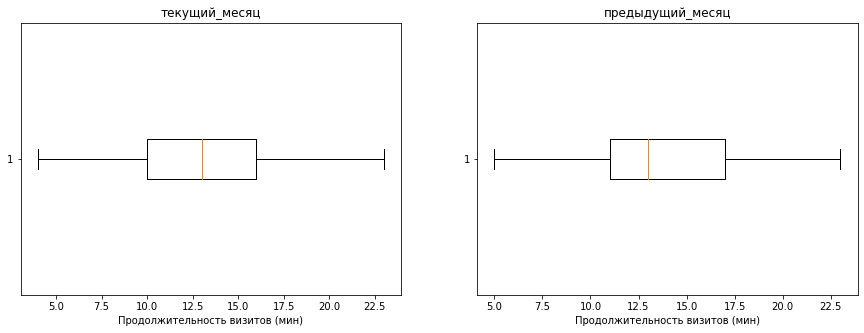

In [32]:
periods = visits['Период'].unique()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
for i in range(0, len(periods)):
    axes[i].hist(visits[visits['Период'] == periods[i]]['минут'], bins=10)
    axes[i].set_xlabel('Продолжительность визитов (мин)')
    axes[i].set_title(periods[i])
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
for i in range(0, len(periods)):
    axes[i].boxplot(visits[visits['Период'] == periods[i]]['минут'], vert=False)
    axes[i].set_xlabel('Продолжительность визитов (мин)')
    axes[i].set_title(periods[i])
plt.show()

### Поведение на сайте - категориальные данные

Распределение долей по показателю  Покупательская_активность
--------------------------------------------------------------------------------------------------------------


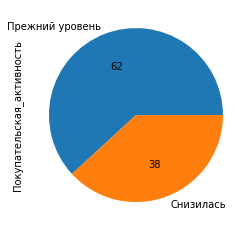

Распределение долей по показателю  Тип_сервиса
--------------------------------------------------------------------------------------------------------------


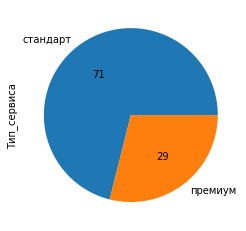

Распределение долей по показателю  Разрешить_сообщать
--------------------------------------------------------------------------------------------------------------


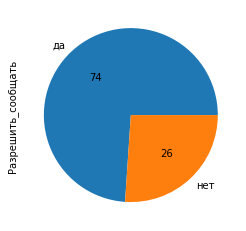

Распределение долей по показателю  Популярная_категория
--------------------------------------------------------------------------------------------------------------


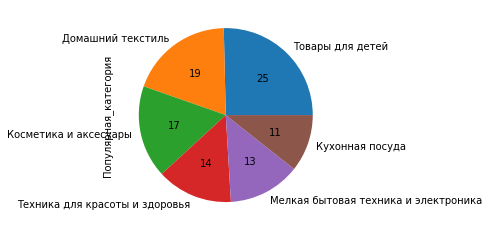

In [33]:
cat_inds = marketing.select_dtypes(include='object').columns

for column in cat_inds:
    stat_plots(marketing[column])

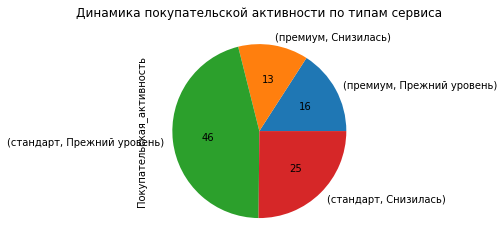

In [34]:
marketing.groupby('Тип_сервиса')['Покупательская_активность'].value_counts().plot(kind='pie', autopct='%.0f', legend=False, ylabel=None, xlabel=None)
plt.title('Динамика покупательской активности по типам сервиса')
plt.show()

### Поведение на сайте - численные данные

Статистический анализ показателя  Маркет_актив_6_мес
--------------------------------------------------------------------------------------------------------------


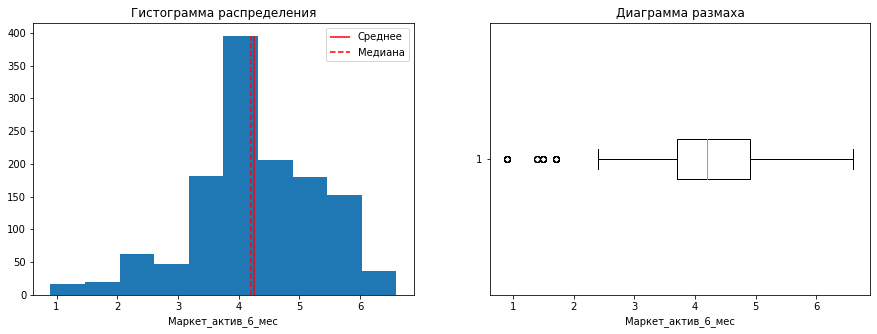

Статистический анализ показателя  Маркет_актив_тек_мес
--------------------------------------------------------------------------------------------------------------


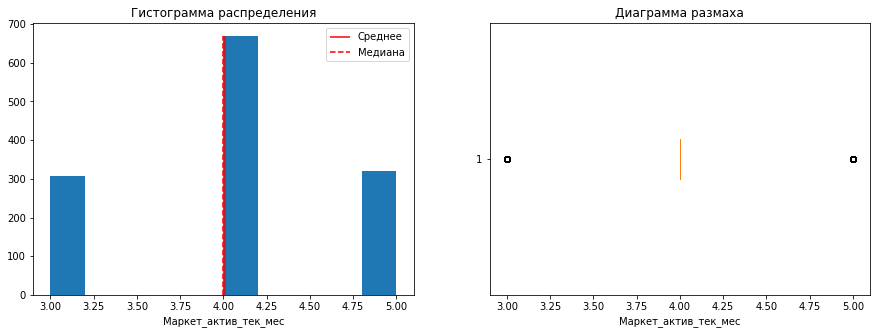

Статистический анализ показателя  Длительность
--------------------------------------------------------------------------------------------------------------


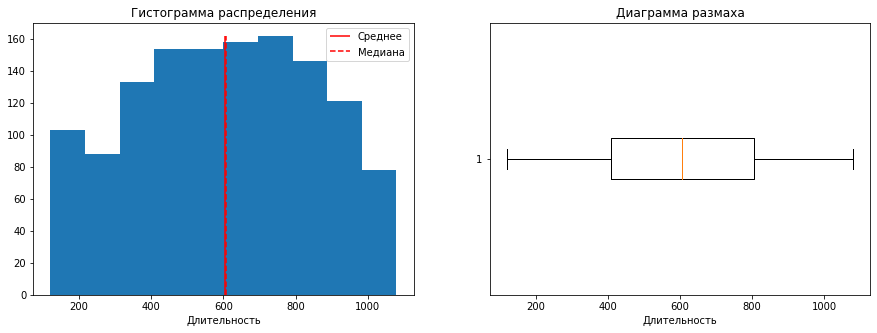

Статистический анализ показателя  Акционные_покупки
--------------------------------------------------------------------------------------------------------------


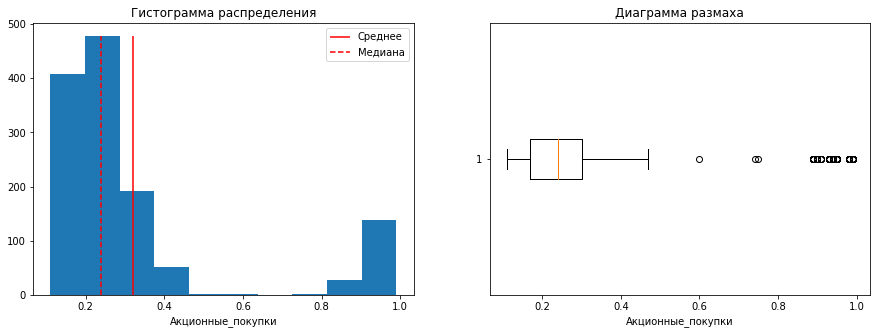

Статистический анализ показателя  Средний_просмотр_категорий_за_визит
--------------------------------------------------------------------------------------------------------------


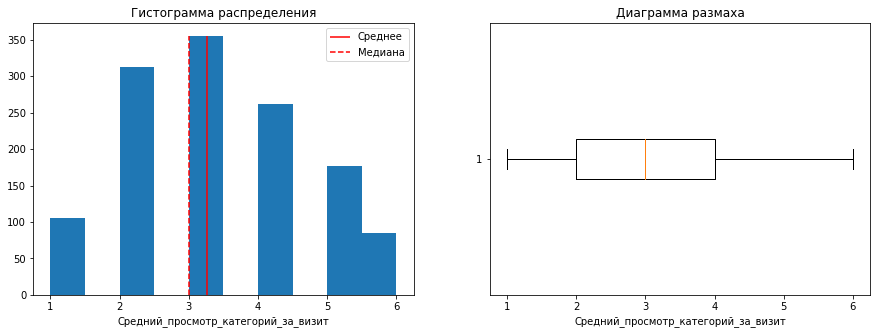

Статистический анализ показателя  Неоплаченные_продукты_штук_квартал
--------------------------------------------------------------------------------------------------------------


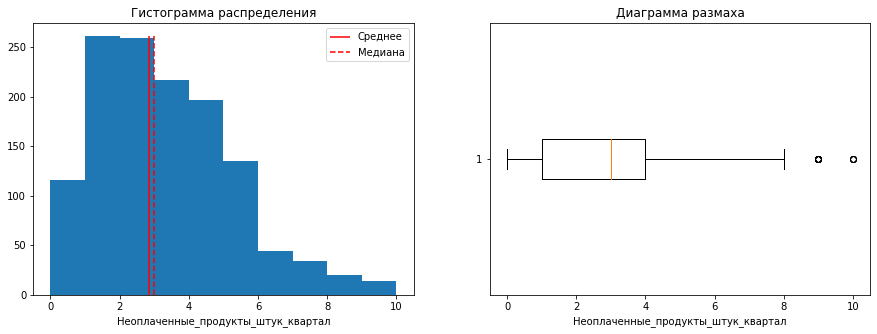

Статистический анализ показателя  Ошибка_сервиса
--------------------------------------------------------------------------------------------------------------


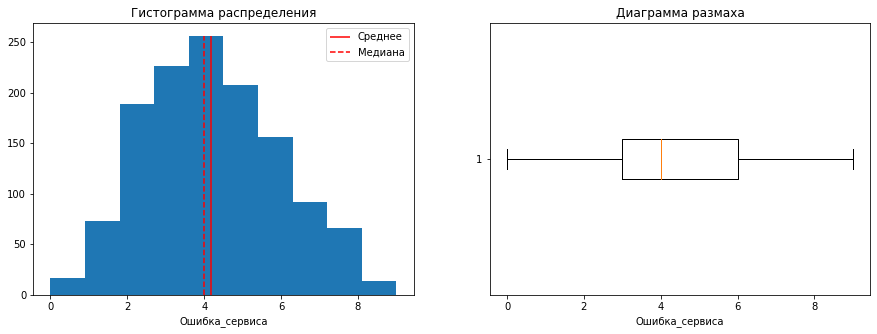

Статистический анализ показателя  Страниц_за_визит
--------------------------------------------------------------------------------------------------------------


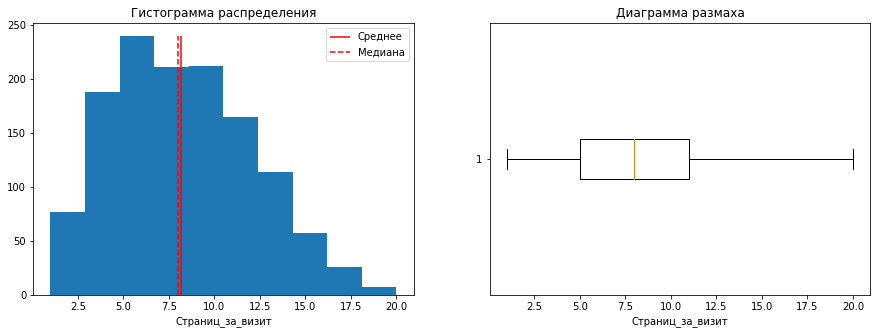

In [35]:
num_inds = marketing.select_dtypes(exclude='object').columns
skip = ['id']

for column in num_inds:
    stat_plots(marketing[column], skip)

### Промежуточный вывод

**Данные о выручке**\
Выручка по месяцам показывает близкую к нормальному распределению картину, медианное значение выручки растет.

**Данные о прибыли**\
Картина распределения совокупной прибыли клиентов также похожа на нормальную, есть небольшое количество выбросов в обе стороны

**Данные о продолжительности визитов**\
Продолжительность визитов сайта в текущем месяце имеет близкое к нормальному распределение, а в предыдущем месяце можно наблюдать странный провал в районе наиболее типичного значения - возможно это было вызвано ошибками сервиса в этот период.

**Данные о поведении на сайте**
- Снижение покупательской активности зарегистрировано у 38% клиентов
- При этом, снижение покупательской активности чаще отмечается среди премиальных клиентов
- Основная масса клиентов согласна получать маркетинговые рассылки
- Топ-3 популярных категорий: Товары для детей, Домашний тесктиль, Косметика и аксессуары
- Численные данные о поведении на сайте в основной своей массе распределены ненормально, за исключением ошибок сервиса, количества страниц и просматриваемых категорий за визит
- Данные об акционных покупках показывают, что существует целая группа клиентов, которая покупает товары только по акциям.
- Количество маркетинговых коммуникаций в текущем месяце выглядит строго регламентированным
- При этом данные о маркетинговой активности за 6 месяцев показывают, что ряду клиентов уделялось очень мало внимания

## Объединение таблиц

Выведем размерности объединяемых таблиц для контроля целостности данных в процессе объединения:

In [36]:
display(revenue.shape)
display(visits.shape)
display(marketing.shape)

(3891, 3)

(2594, 3)

(1297, 13)

Выведем значения выручки по месяцам в отдельные столбцы:

In [37]:
revenue_split = revenue.pivot_table(index='id', columns='Период')
revenue_split.columns = ['Выручка_мес2', 'Выручка_мес1', 'Выручка_мес3']
revenue_split.shape

(1297, 3)

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Отлично!  Развернули таблицы.</font>

Создадим объединенный датафрейм, присоединив к данным о маркетинге полученную таблицу выручки:

In [38]:
data = marketing.merge(revenue_split, on='id')
data.shape

(1297, 16)

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> Верно, при объединении таблиц нужно привязаться к уникальному `"id"`.</font>

Выведем значения продолжительности посещений сайта по месяцам в отдельные столбцы:

In [39]:
visits_split = visits.pivot_table(index='id', columns='Период')
visits_split.columns = ['Длит_посещ_мес2', 'Длит_посещ_мес3']
visits_split.shape

(1297, 2)

Добавим полученную таблицу в объединенный датафрейм:

In [40]:
data = data.merge(visits_split, on='id')
display(data.shape)
data.head(5)

(1297, 18)

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_мес2,Выручка_мес1,Выручка_мес3,Длит_посещ_мес2,Длит_посещ_мес3
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216,4472,4971,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457,4826,5058,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158,4793,6610,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807,4594,5872,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738,5124,5388,10,10


Заменим индексы датафрейма на идентификаторы клиентов:

In [41]:
data = data.set_index('id')

## Корреляционный анализ

Сформируем матрицу корреляции на базе коэффициента Phi_K для объединенного датасета :

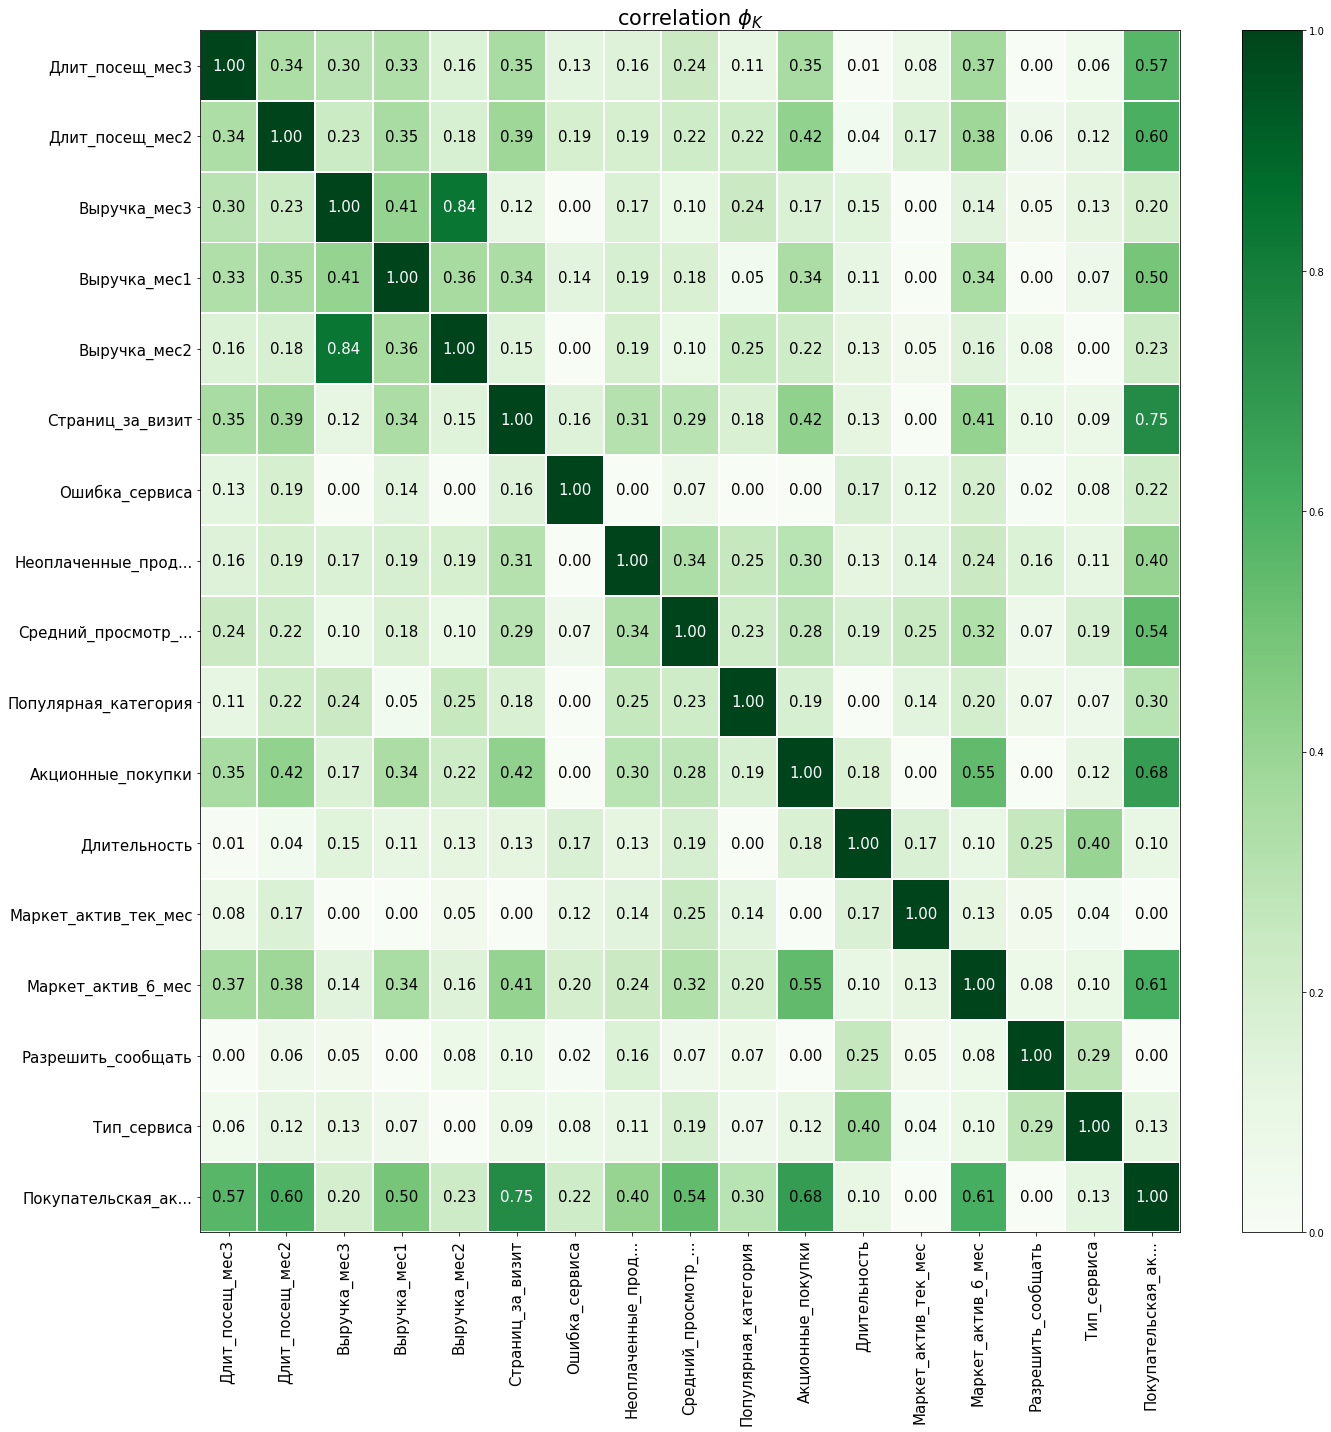

In [42]:
#выделим перечень колонок с непрерывными данными
interval_cols = ['Длительность', 'Выручка_мес2', 'Выручка_мес1', 'Выручка_мес3']

#построим матрицу корреляции
phik_overview = phik_matrix(data, interval_cols=interval_cols)

#отобразим матрицу корреляции на тепловой карте
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 20)
)

Мы можем видеть высокую корреляцию между выручкой текущего и предыдущего месяцев, но значение коэффициента корреляции ниже 0.9, что не позволяет утверждать о наличии мультиколлинеарности.

## Настройка пайплайнов

Выделим целевой признак:

In [43]:
X = data.drop('Покупательская_активность', axis=1)
y = data['Покупательская_активность']

Разделим данные на выборки и выведем первые пять значений целевого признака для дальнейшего контроля кодировки:

In [44]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
y_train[0:5]

id
216259    Прежний уровень
216044    Прежний уровень
215441          Снизилась
215841          Снизилась
215594          Снизилась
Name: Покупательская_активность, dtype: object

Закодируем целевой признак и выясним принцип кодировки:

In [45]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_train[0:5]

array([0, 0, 1, 1, 1])

**Как мы видим, снижение покупательской активности было закодировано как Positive**

Разделим признаки по типам для разных способов кодировки.\
Признак "Тип_сервиса" будем кодировать путем ранжирования. 

In [46]:
ignore = ['id']
ohe_columns = ['Разрешить_сообщать', 'Популярная_категория']
ord_columns = ['Тип_сервиса']
num_columns = X.columns[~X.columns.isin(ohe_columns + ord_columns + ignore)]

Инициализируем шаг пайплайна для кодировщика OneHotEncoder

In [47]:
ohe_pipe = Pipeline(
    [
        (
            'ohe', 
            OneHotEncoder(drop='first', sparse=False)
        )
    ]
)

Инициализируем шаг пайплайна для кодировщика OrdinalEncoder

In [48]:
ord_pipe = Pipeline(
    [
        (
            'ord',  
            OrdinalEncoder(categories=[['стандарт', 'премиум']])
        ),
    ]
)

Создадим пайплайн предобработки данных

In [49]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', sparse=False), ohe_columns),
        ('ord', OrdinalEncoder(), ord_columns),
        ('num', MinMaxScaler(), num_columns),
    ], 
    remainder='passthrough' 
)

Создадим пайплайн для подбора гиперпараметров

In [50]:
pipe_test =  Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', 'passthrough')
])

## Подбор гиперпараметров

### Выбор метрики

Поскольку значение "Снизилась" целевого признака "Покупательская активность" было закодировано как 1 (то есть Positive), а целью прогнозирования является выявление максимального числа клиентов с риском снижения покупательской активности, при оценке качества модели нам нужно минимизировать количество неверных предсказаний о снижении покупательской активности, то есть минимизировать False Negative Rate.

Создадим кастомную метрику для расчета False Negative Rate

In [51]:
fnr_score = make_scorer(
    get_false_negative_rate, #ранее определенная функция
    greater_is_better=False
)

</font><font color='purple'>
    <b>Комментарий студента: </b> Исправлено.
    </font>

### Индивидуальный пайплайн

Создадим словарь параметров для индивидуального пайплайна.\
Будем использовать модель kNN с количеством соседей от 2 до 5, и три способа масштабирования числовых данных.

In [52]:
param_grid = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 6),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']
    }
]

Инициализируем класс GridSearchCV с мультискорингом и передадим ему:
- в качестве параметра словарь param_grid
- в качестве метрики словарь с метриками scoring

In [53]:
cv_test = GridSearchCV(
    pipe_test,
    param_grid,
    n_jobs=-1,
    cv=5,
    scoring=fnr_score
)

Выполним подбор параметров путем перебора всех комбинаций и выведем результаты:

In [54]:
warnings.filterwarnings('ignore')
cv_test.fit(X_train, y_train)
best_params = cv_test.best_params_
print(f'{"Лучшее значение FNR:":<30} {(cv_test.best_score_).round(2)}')
print(f'{"Лучшая модель и ее параметры:":<30} {best_params["models"]}')
print(f'{"Лучший кодировщик:":<30} {best_params["preprocessor__num"]}')

Лучшее значение FNR:           -0.24
Лучшая модель и ее параметры:  KNeighborsClassifier()
Лучший кодировщик:             RobustScaler()


Обучим модель с рекомендованными параметрами и получим предсказания:

In [55]:
best_suite = cv_test.best_estimator_
best_suite.fit(X_train, y_train)
y_pred = best_suite.predict(X_test)

Рассчитаем метрики выбранной модели и матрицу ошибок:

In [56]:
metrics_grid(y_test, y_pred)

,Метрика,Значение
0,Accuracy,0.89
1,Precision,0.89
2,Recall,0.82


In [57]:
print(f'FNR модели: {get_false_negative_rate(y_test, y_pred).round(2)}')

FNR модели: 0.18


In [58]:
FNR_mean = cross_val_score(best_suite, X_train, y_train, cv=5, scoring = fnr_score).mean()
print(f'Значение FNR при кросс-валидации: {FNR_mean.round(2)}')

Значение FNR при кросс-валидации: -0.24


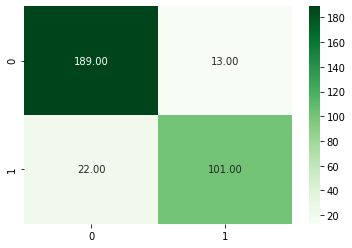

In [59]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.2f', cmap='Greens')
plt.show()

### Полный пайплайн

Зададим набор моделей, их гиперпараметров и инструментов масштабирования, для полного пайплайна:

In [60]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(kernel = 'poly', probability=True, random_state=RANDOM_STATE)],
        'models__degree': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']
    }
]

In [61]:
cv_test = RandomizedSearchCV(
    pipe_test,
    param_grid,
    scoring=fnr_score,
    n_jobs=-1,
    cv=5,
    n_iter=10,
    random_state=RANDOM_STATE
)

Передадим тренировочные данные в пайплайн 

In [62]:
cv_test.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse=False),
                                                                               ['Разрешить_сообщать',
                                                                                'Популярная_категория']),
                                                                              ('ord',
                                                                               OrdinalEncoder(),
                                                                               ['Тип_сервиса']),
                                   

Построим таблицу результатов:

In [63]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(cv_test.cv_results_)
result[
    ['rank_test_score', 'mean_test_score', 'param_preprocessor__num', 'params']
].sort_values('rank_test_score')

,rank_test_score,mean_test_score,param_preprocessor__num,params
4,1,-0.233257,RobustScaler(),"{'preprocessor__num': RobustScaler(), 'models__C': 5, 'models': LogisticRegression(C=5, penalty='l1', random_state=88, solver='liblinear')}"
3,2,-0.251497,MinMaxScaler(),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 5, 'models__max_depth': 9, 'models': DecisionTreeClassifier(random_state=88)}"
7,3,-0.285521,passthrough,"{'preprocessor__num': 'passthrough', 'models__max_features': 4, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=88)}"
2,4,-0.299667,passthrough,"{'preprocessor__num': 'passthrough', 'models__max_features': 4, 'models__max_depth': 9, 'models': DecisionTreeClassifier(random_state=88)}"
8,5,-0.305285,StandardScaler(),"{'preprocessor__num': StandardScaler(), 'models__max_features': 9, 'models__max_depth': 8, 'models': DecisionTreeClassifier(random_state=88)}"
1,6,-0.317858,passthrough,"{'preprocessor__num': 'passthrough', 'models__max_features': 6, 'models__max_depth': 9, 'models': DecisionTreeClassifier(random_state=88)}"
5,7,-0.319160,StandardScaler(),"{'preprocessor__num': StandardScaler(), 'models__max_features': 3, 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=88)}"
0,8,-0.326118,passthrough,"{'preprocessor__num': 'passthrough', 'models__max_features': 6, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=88)}"
6,9,-0.400933,RobustScaler(),"{'preprocessor__num': RobustScaler(), 'models__max_features': 2, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=88)}"
9,10,-0.778141,passthrough,"{'preprocessor__num': 'passthrough', 'models__degree': 9, 'models': SVC(kernel='poly', probability=True, random_state=88)}"


Зафиксируем лучшие результаты для калибровки итогового пайплайна:

In [64]:
result = pd.DataFrame(cv_test.cv_results_)
best_score = result['rank_test_score'].min()
pos = result[result['rank_test_score'] == best_score].index
best_model_params = result.loc[pos, 'param_models'].iloc[0]
best_scaler = result.loc[pos, 'params'].iloc[0]['preprocessor__num']
print(f'{"Лучшее значение FNR:":<30} {result.loc[pos, "mean_test_score"].iloc[0].round(2)}')
print(f'{"Лучшая модель и ее параметры:":<30} {best_model_params}')
print(f'{"Лучший кодировщик:":<30} {best_scaler}')

Лучшее значение FNR:           -0.23
Лучшая модель и ее параметры:  LogisticRegression(C=5, penalty='l1', random_state=88, solver='liblinear')
Лучший кодировщик:             RobustScaler()


Передадим лучшие результаты в итоговый пайплайн:

In [65]:
best_suite = cv_test.best_estimator_

Обучим модель при помощи итогового пайплайна и получим предсказания на тестовой выборке:

In [66]:
best_suite.fit(X_train, y_train)
y_pred = best_suite.predict(X_test)

Вычислим метрики получившейся модели:

In [67]:
metrics_grid(y_test, y_pred)

,Метрика,Значение
0,Accuracy,0.90
1,Precision,0.90
2,Recall,0.84


In [68]:
print(f'FNR модели: {get_false_negative_rate(y_test, y_pred).round(2)}')

FNR модели: 0.16


<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Тестирование проведено верно.</font>

In [69]:
FNR_mean = cross_val_score(best_suite, X_train, y_train, cv=5, scoring = fnr_score).mean()
print(f'Значение FNR при кросс-валидации: {FNR_mean.round(2)}')

Значение FNR при кросс-валидации: -0.23


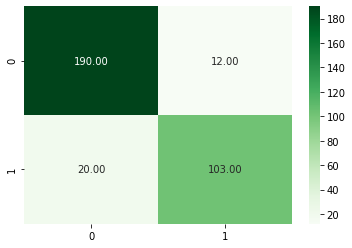

In [70]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.2f', cmap='Greens')
plt.show()

## Анализ важности признаков

Подготовим данные для моделирования, используя методы кодировки и масштабирования из лучшего пайплайна по результатам подбора:

In [71]:
print(f'{"Лучшая модель и ее параметры:":<30} {best_model_params}')
print(f'{"Лучший кодировщик:":<30} {best_scaler}')

Лучшая модель и ее параметры:  LogisticRegression(C=5, penalty='l1', random_state=88, solver='liblinear')
Лучший кодировщик:             RobustScaler()


In [72]:
#кодировка OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = ohe.fit_transform(X_train[ohe_columns])
X_test_ohe = ohe.transform(X_test[ohe_columns])
encoder_col_names = ohe.get_feature_names()
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

# масштабирование
scaler = RobustScaler()
X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])

#кодировка OrdinalEncoder
ore = OrdinalEncoder()
X_train[ord_columns] = ore.fit_transform(X_train[ord_columns])
X_test[ord_columns] = ore.transform(X_test[ord_columns])

# обнуляем индексы строк
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# объедините количественные и категориальные признаки для тренировочного
X_train = pd.concat([X_train[num_columns], X_train_ohe, X_train[ord_columns]], axis=1)
X_test = pd.concat([X_test[num_columns], X_test_ohe, X_test[ord_columns]], axis=1)

Инициализируем, обучим модель и получим предсказания:

In [73]:
best_model = LogisticRegression(C=5, penalty='l1', random_state=RANDOM_STATE, solver='liblinear')
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

Рассчитаем метрики модели:

In [74]:
metrics_grid(y_test, y_pred)

,Метрика,Значение
0,Accuracy,0.90
1,Precision,0.90
2,Recall,0.84


In [75]:
print(f'FNR модели: {get_false_negative_rate(y_test, y_pred).round(2)}')

FNR модели: 0.16


Построим матрицу ошибок

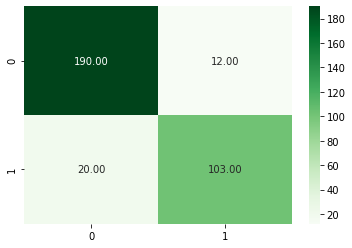

In [76]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.2f', cmap='Greens')
plt.show()

Построим диаграмму значений Шепли для итоговой модели:

TypeError: set_ticks() got an unexpected keyword argument 'fontsize'

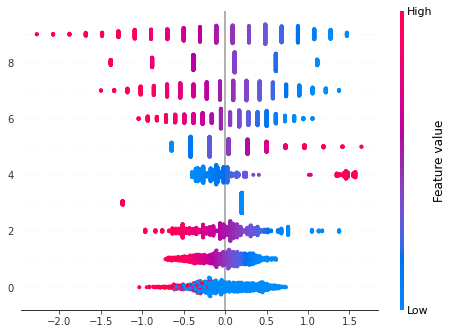

In [77]:
explainer = shap.LinearExplainer(best_model, X_train)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

### Вывод по этапу

Как мы можем видеть на диаграмме SHAP, при формировании прогнозов наша модель практически не учитывает такие признаки, как:
- Количество коммуникаций в текущем месяце
- Уровень сервиса клиента
- Количество ошибок сервиса
- Отказ клиента от маркетинговых рассылок

Такие признаки можно исключить из анализа, поскольку их обработка только будет потреблять вычислительные мощности.

В то же время, самым значительным влиянием на прогнозирование модель считает признаки:
- Количество просматриваемых пользователем страниц за визит
- Среднее количество просматриваемых товарных категорий за визит
- Длительность посещений сайта
- Среднее количество неоплаченных товаров в корзине
- Среднемесячная доля покупок по акции от общего числа покупок

На таких признаках имеет смысл сделать упор при моделировании, попробовать преобразовать их или внедрить новые признаки на основе их комбинаций.

Показатели с высовой значимостью мы можем использовать для идентификации фокус-групп покупателей, склонных к снижению покупательской активности. Например, выделить сегмент покупателей с низкими показателями активности на сайте, большим количеством неоплаченных товаров в корзине и высокой долей покупок по акциям, и сформировать для этой группы персонализированные предложения.

## Выбор целевого сегмента

Добавим данные о прибыли по клиентам и построим новую таблицу сегментации:

In [ ]:
segmentation = data.drop('Покупательская_активность', axis=1).merge(money_totals(), on='id').set_index('id')

Подготовим данные для моделирования:

In [ ]:
X_probe = X
#кодировка OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse=False)
X_probe_ohe = ohe.fit_transform(X_probe[ohe_columns])
encoder_col_names = ohe.get_feature_names()
X_probe_ohe = pd.DataFrame(X_probe_ohe, columns=encoder_col_names)

# масштабирование
scaler = RobustScaler()
X_probe[num_columns] = scaler.fit_transform(X_probe[num_columns])

#кодировка OrdinalEncoder
ore = OrdinalEncoder()
X_probe[ord_columns] = ore.fit_transform(X_probe[ord_columns])

# обнуляем индексы строк
X_probe = X_probe.reset_index(drop=True)

# объедините количественные и категориальные признаки для тренировочного
X_probe = pd.concat([X_probe[num_columns], X_probe_ohe, X_probe[ord_columns]], axis=1)

Вычислим вероятности снижения покупательской активности и запишем их в новый столбец:

In [ ]:
segmentation['Вероятность_снижения'] = best_model.predict_proba(X_probe)[:,1]

Установим пороги классификации и разделим выборку на сегменты

In [ ]:
proba_threshold = 0.7
profit_threshold = 3000

focus_group = segmentation[(segmentation['Вероятность_снижения'] >= proba_threshold) & (segmentation['Прибыль'] >= profit_threshold)]
others = segmentation.drop(focus_group.index)

Отобразим целевой сегмент на диаграмме рассеяния

In [ ]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=focus_group, x='Вероятность_снижения', y='Прибыль', label='Фокус-группа', color='red')
sns.scatterplot(data=others, x='Вероятность_снижения', y='Прибыль', label='Остальные', color='blue')
plt.legend()
plt.axvline(x=proba_threshold, color='purple', linestyle='--')
plt.axhline(y=profit_threshold, color='purple', linestyle='--')
plt.show()

Создадим метку целевого сегмента и разметим таблицу сегментации

In [ ]:
focus_group['Сегмент'] = 'Фокус-группа'
segmentation = segmentation.merge(focus_group['Сегмент'], on='id', how='left')
segmentation['Сегмент'] = segmentation['Сегмент'].fillna('Остальные')

Сформируем выборки по сегментам и построим для них графики по всем показателям датасета:

In [ ]:
focus = segmentation[segmentation['Сегмент'] == 'Фокус-группа']
others = segmentation[segmentation['Сегмент'] != 'Фокус-группа']

In [ ]:
for indicator in num_columns:
    sns.histplot(data=others[indicator], color='blue')
    sns.histplot(data=focus[indicator], color='red', bins=10)
    plt.axvline(x=others[indicator].median(), color='blue', linestyle='--')
    plt.axvline(x=focus[indicator].median(), color='red', linestyle='--')
    plt.ylabel('Количество клиентов')
    plt.show()

Как мы можем видеть на графиках, для клиентов нашей целевой группы характерно следующее:

**Продуктовое поведение**
- Малое количество просматриваемых категорий в среднем за визит
- Много неоплаченных товаров
- Много акционных покупок

**Поведение на сайте**
- Низкая длительность посещения сайта
- Мало страниц за визит

**Финансовое поведение**
- Низкая выручка в позапрошлом месяце

Также мы можем наблюдать следующие параметры уровня коммуникаций с клиентами целевой группы:
- Малое количество маркетинговых коммуникаций за прошедшие 6 месяцев
- Давний срок регистрации на сайте (старые клиенты)

## Итоговый вывод

В этом проекте мы анализировали данные о потребительском поведении и финансовых результатах работы интернет-магазина «В один клик».\
Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться и магазин заинтересован в удержании постоянных клиентов с помощью персонализированных предложений.\
Задачей проекта являлось разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

В качестве исходных данных в нашем распоряжении были:
- Таблица, которая содержит данные о поведении покупателя на сайте
- Таблица с данными о выручке, которую получает магазин с покупателя
- Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- Таблица с данными о среднемесячной прибыли магазина за последние 3 месяца

В процессе предобработки данных были выполнены следующие операции:
- Устранено несколько опечаток, некоторые из которых приводили к дублированию данных.
- Заменены пробелы в названиях столбцов.
- Приведены к одной единице измерения и размерности данные о выручке и прибыли.

Для поиска лучшей модели мы использовали инструмент подбора гиперпараметров **Randomized Search** с кросс-валидацией.\
Для кодировки категориальных данных были задействованы кодировщики **One Hot Encoder** и **Ordinal Encoder**, целевой признак мы закодировали с помощью **Label Encoder**.\
Подбор наилучшей комбинации модели, гиперпараметров и инструментов масштабирования был произведен путем построения полного пайплайна, которому на выбор были предоставлены модели:
- **KNeighborsClassifier()**
- **DecisionTreeClassifier()**
- **LogisticRegression()**
- **SVC()**\
и следующие инструменты маштабирования количественных признаков:
- **Standard Scaler**
- **Min-Max Scaler**
- **Robust Scaler**

Подбор лучшей комбинации производился на основании минимизации метрики False Negative Rate.

По результатам подбора наилучшие показатели продемонстрировали следующая модель и скейлер:\
Лучшая модель и ее параметры:  **LogisticRegression(C=5, penalty='l1', random_state=88, solver='liblinear')**\
Лучший кодировщик:             **RobustScaler()**

При помощи выбранной модели были сформированы предсказания вероятности снижения покупательской активности всех клиентов магазина, после чего был выделен целевой сегмент по критериям величины порога вероятности и уровня среднемесячной прибыли.

**Рекомендации по результатам анализа показателей целевого сегмента:**
* Имеет смысл увеличить количество маркетинговых активностей в отношении сформированной фокус-группы покупателей
* Регулярно реализовывать маркетинговые акции для целевого сегмента покупателей, по всем категориям товарного каталога
* При разработке акции отдавать приоритет товарным группам неоплаченных товаров в корзинах клиентов целевого сегмента